$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/ofir.s/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/ofir.s/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/ofir.s/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


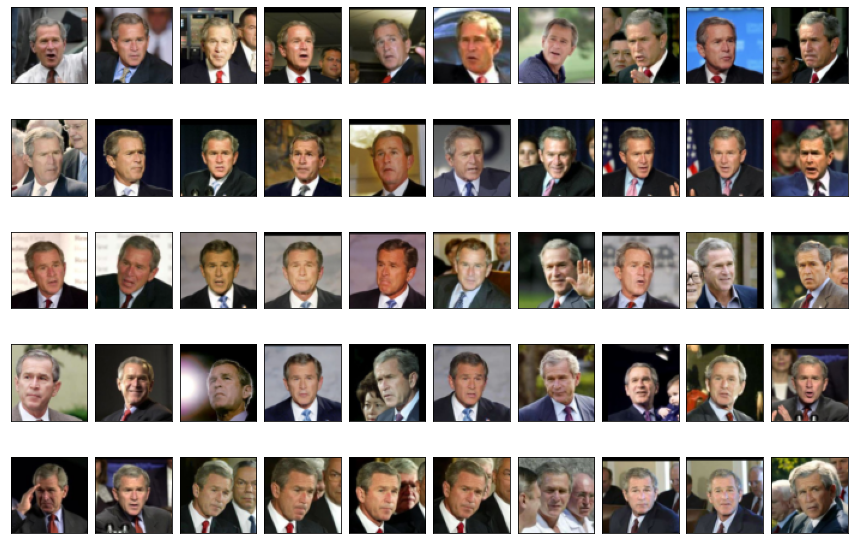

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

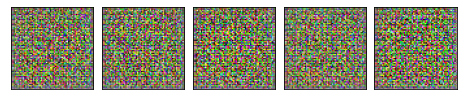

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [123]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams
torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)
print(len(list(dsc.parameters())))
print(len(list(gen.parameters())))

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

11
13
{'batch_size': 53, 'z_dim': 100, 'data_label': 1, 'label_noise': 0.0, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}}


In [124]:
print(gen)
print(dsc)

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0):

**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
Discriminator loss: 0.3671745128929615
Generator loss:     5.234097242355347
Saved checkpoint.


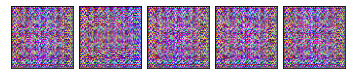

--- EPOCH 2/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.76it/s]
Discriminator loss: 0.06861362904310227
Generator loss:     8.368956184387207
Saved checkpoint.


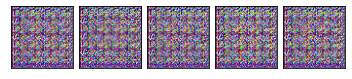

--- EPOCH 3/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.95it/s]
Discriminator loss: 0.13939388068392872
Generator loss:     11.902281761169434
Saved checkpoint.


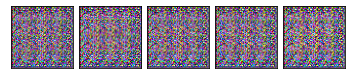

--- EPOCH 4/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.2198765046428889
Generator loss:     16.845157861709595
Saved checkpoint.


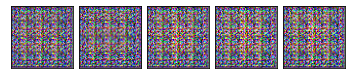

--- EPOCH 5/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.24476513029076158
Generator loss:     15.788241004943847
Saved checkpoint.


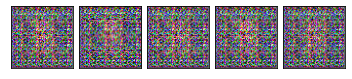

--- EPOCH 6/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.22it/s]
Discriminator loss: 1.0340569023042918
Generator loss:     14.15561785697937
Saved checkpoint.


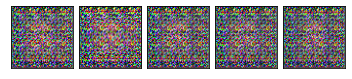

--- EPOCH 7/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.90it/s]
Discriminator loss: 0.30864721280522645
Generator loss:     11.196466112136841
Saved checkpoint.


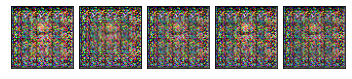

--- EPOCH 8/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
Discriminator loss: 0.6642166132107377
Generator loss:     10.323365926742554
Saved checkpoint.


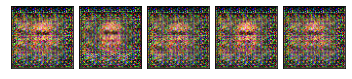

--- EPOCH 9/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.76it/s]
Discriminator loss: 0.8250822898000478
Generator loss:     9.217443943023682
Saved checkpoint.


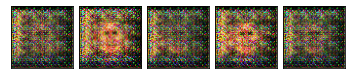

--- EPOCH 10/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
Discriminator loss: 0.3997971273958683
Generator loss:     8.155974912643433
Saved checkpoint.


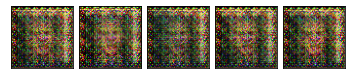

--- EPOCH 11/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.60it/s]
Discriminator loss: 0.36635537520051004
Generator loss:     8.072034668922424
Saved checkpoint.


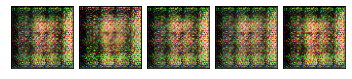

--- EPOCH 12/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.25it/s]
Discriminator loss: 0.8742581456899643
Generator loss:     8.523951077461243
Saved checkpoint.


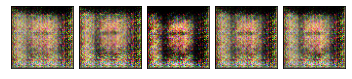

--- EPOCH 13/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.92it/s]
Discriminator loss: 0.6570882946252823
Generator loss:     6.031229019165039
Saved checkpoint.


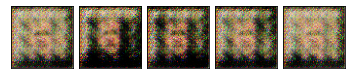

--- EPOCH 14/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.87it/s]
Discriminator loss: 0.6450348377227784
Generator loss:     4.810732984542847
Saved checkpoint.


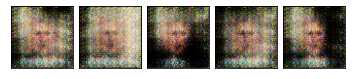

--- EPOCH 15/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.86it/s]
Discriminator loss: 0.869429636001587
Generator loss:     3.6148760080337525
Saved checkpoint.


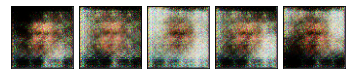

--- EPOCH 16/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.86it/s]
Discriminator loss: 0.9601533591747284
Generator loss:     3.2299256503582
Saved checkpoint.


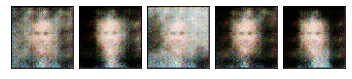

--- EPOCH 17/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.5773584604263305
Generator loss:     3.107592153549194
Saved checkpoint.


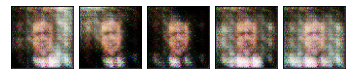

--- EPOCH 18/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.14it/s]
Discriminator loss: 0.8697972416877746
Generator loss:     4.256694543361664
Saved checkpoint.


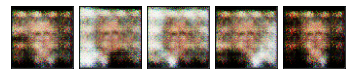

--- EPOCH 19/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.51it/s]
Discriminator loss: 0.6154754489660264
Generator loss:     3.3599726438522337
Saved checkpoint.


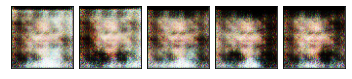

--- EPOCH 20/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.90it/s]
Discriminator loss: 0.5467183291912079
Generator loss:     4.1073591947555546
Saved checkpoint.


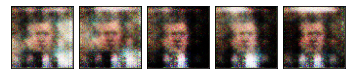

--- EPOCH 21/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.86it/s]
Discriminator loss: 0.5535618290305138
Generator loss:     4.4839022397995
Saved checkpoint.


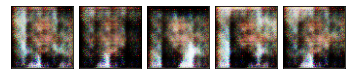

--- EPOCH 22/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.68it/s]
Discriminator loss: 0.7354930460453033
Generator loss:     5.571327888965607
Saved checkpoint.


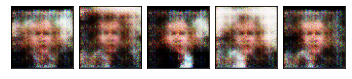

--- EPOCH 23/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.05it/s]
Discriminator loss: 0.8352609574794769
Generator loss:     4.5402463555336
Saved checkpoint.


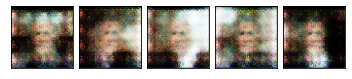

--- EPOCH 24/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.7591171532869339
Generator loss:     3.6969616174697877
Saved checkpoint.


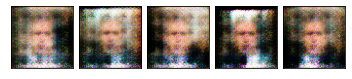

--- EPOCH 25/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.19it/s]
Discriminator loss: 0.5598480641841889
Generator loss:     4.674842953681946
Saved checkpoint.


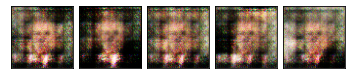

--- EPOCH 26/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.81it/s]
Discriminator loss: 0.4137731045484543
Generator loss:     4.454572176933288
Saved checkpoint.


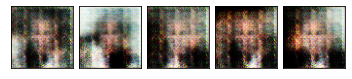

--- EPOCH 27/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
Discriminator loss: 1.015771034359932
Generator loss:     4.136494278907776
Saved checkpoint.


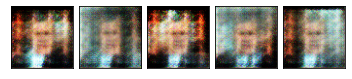

--- EPOCH 28/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.41it/s]
Discriminator loss: 0.41747898757457735
Generator loss:     3.9816954135894775
Saved checkpoint.


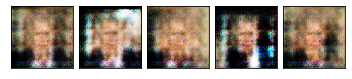

--- EPOCH 29/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.91it/s]
Discriminator loss: 0.7302517503499985
Generator loss:     3.660726451873779
Saved checkpoint.


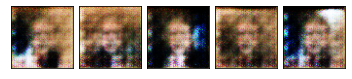

--- EPOCH 30/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.28it/s]
Discriminator loss: 0.6833450704813003
Generator loss:     4.024671411514282
Saved checkpoint.


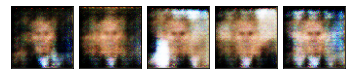

--- EPOCH 31/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
Discriminator loss: 0.5959815382957458
Generator loss:     4.491953587532043
Saved checkpoint.


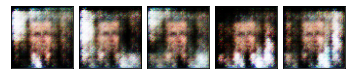

--- EPOCH 32/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.6544590085744858
Generator loss:     4.496288275718689
Saved checkpoint.


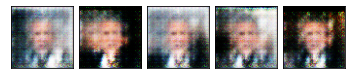

--- EPOCH 33/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.15it/s]
Discriminator loss: 0.7380784541368485
Generator loss:     4.155809891223908
Saved checkpoint.


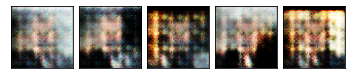

--- EPOCH 34/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
Discriminator loss: 0.4233805567026138
Generator loss:     3.712871623039246
Saved checkpoint.


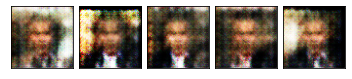

--- EPOCH 35/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.68it/s]
Discriminator loss: 0.701426300406456
Generator loss:     4.712967133522033
Saved checkpoint.


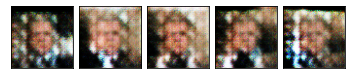

--- EPOCH 36/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.465262234210968
Generator loss:     4.068362784385681
Saved checkpoint.


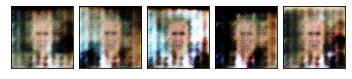

--- EPOCH 37/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.58it/s]
Discriminator loss: 0.8541356384754181
Generator loss:     4.842860007286072
Saved checkpoint.


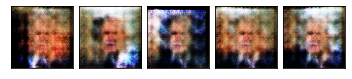

--- EPOCH 38/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.77it/s]
Discriminator loss: 0.5427269279956818
Generator loss:     4.04775595664978
Saved checkpoint.


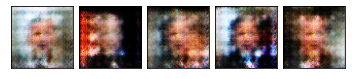

--- EPOCH 39/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.41it/s]
Discriminator loss: 0.5066128432750702
Generator loss:     3.7894655227661134
Saved checkpoint.


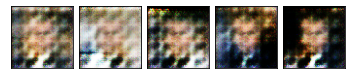

--- EPOCH 40/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.34it/s]
Discriminator loss: 0.7271836414933205
Generator loss:     4.808400177955628
Saved checkpoint.


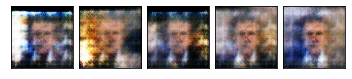

--- EPOCH 41/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.85it/s]
Discriminator loss: 0.816249680519104
Generator loss:     4.123961067199707
Saved checkpoint.


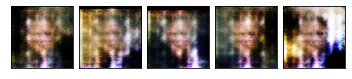

--- EPOCH 42/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.52it/s]
Discriminator loss: 0.5437883347272873
Generator loss:     3.8588605761528014
Saved checkpoint.


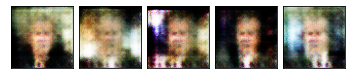

--- EPOCH 43/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.66it/s]
Discriminator loss: 0.5303081572055817
Generator loss:     3.578928768634796
Saved checkpoint.


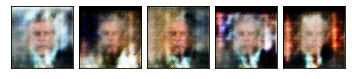

--- EPOCH 44/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.4683458387851715
Generator loss:     3.6304917335510254
Saved checkpoint.


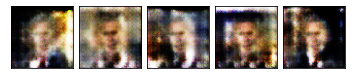

--- EPOCH 45/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.85it/s]
Discriminator loss: 0.9670072734355927
Generator loss:     4.500213408470154
Saved checkpoint.


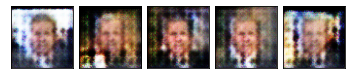

--- EPOCH 46/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.56it/s]
Discriminator loss: 0.6175524324178696
Generator loss:     3.9697798252105714
Saved checkpoint.


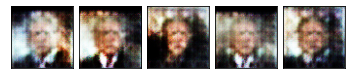

--- EPOCH 47/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.63it/s]
Discriminator loss: 0.9235641300678253
Generator loss:     4.164334547519684
Saved checkpoint.


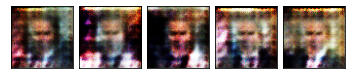

--- EPOCH 48/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.73it/s]
Discriminator loss: 0.4918872356414795
Generator loss:     4.006065440177918
Saved checkpoint.


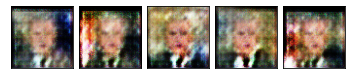

--- EPOCH 49/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.80it/s]
Discriminator loss: 0.8296050071716309
Generator loss:     4.848777961730957
Saved checkpoint.


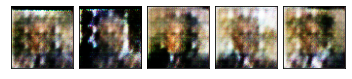

--- EPOCH 50/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.59it/s]
Discriminator loss: 0.5589401513338089
Generator loss:     4.364555978775025
Saved checkpoint.


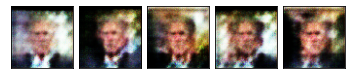

--- EPOCH 51/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
Discriminator loss: 0.6335499972105026
Generator loss:     3.9659011125564576
Saved checkpoint.


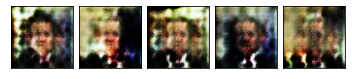

--- EPOCH 52/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.77it/s]
Discriminator loss: 0.435114187002182
Generator loss:     3.833672046661377
Saved checkpoint.


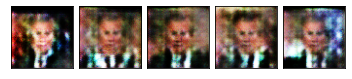

--- EPOCH 53/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.59it/s]
Discriminator loss: 0.46300758719444274
Generator loss:     3.897846794128418
Saved checkpoint.


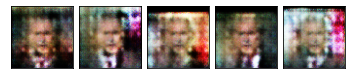

--- EPOCH 54/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.76it/s]
Discriminator loss: 0.5196002095937728
Generator loss:     3.647786521911621
Saved checkpoint.


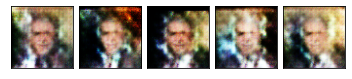

--- EPOCH 55/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.30it/s]
Discriminator loss: 1.1851581186056137
Generator loss:     4.540379530191421
Saved checkpoint.


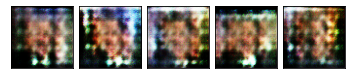

--- EPOCH 56/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.93it/s]
Discriminator loss: 0.5114428550004959
Generator loss:     4.159704804420471
Saved checkpoint.


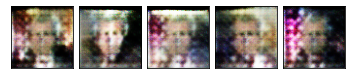

--- EPOCH 57/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.5310341715812683
Generator loss:     3.9702574014663696
Saved checkpoint.


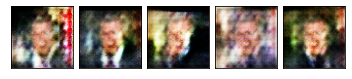

--- EPOCH 58/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
Discriminator loss: 0.49663603901863096
Generator loss:     4.571503973007202
Saved checkpoint.


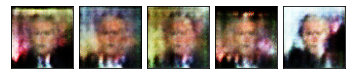

--- EPOCH 59/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.24it/s]
Discriminator loss: 0.5078427940607071
Generator loss:     3.63303964138031
Saved checkpoint.


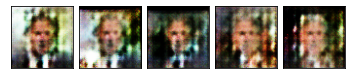

--- EPOCH 60/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.12it/s]
Discriminator loss: 0.4706015229225159
Generator loss:     4.762809586524964
Saved checkpoint.


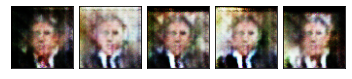

--- EPOCH 61/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.77it/s]
Discriminator loss: 0.7572733640670777
Generator loss:     4.23086678981781
Saved checkpoint.


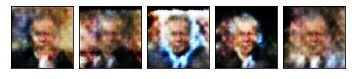

--- EPOCH 62/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.5311809122562409
Generator loss:     3.9428300142288206
Saved checkpoint.


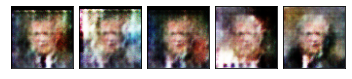

--- EPOCH 63/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.29it/s]
Discriminator loss: 0.7539371609687805
Generator loss:     4.443857681751251
Saved checkpoint.


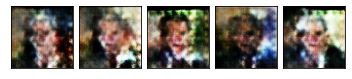

--- EPOCH 64/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.29it/s]
Discriminator loss: 0.6754399567842484
Generator loss:     4.373539924621582
Saved checkpoint.


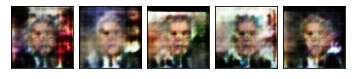

--- EPOCH 65/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
Discriminator loss: 0.4690603256225586
Generator loss:     3.932433605194092
Saved checkpoint.


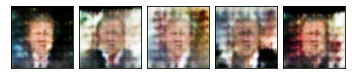

--- EPOCH 66/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.61it/s]
Discriminator loss: 0.5640627473592759
Generator loss:     4.237793803215027
Saved checkpoint.


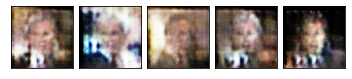

--- EPOCH 67/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.99it/s]
Discriminator loss: 0.6146053150296211
Generator loss:     3.805602419376373
Saved checkpoint.


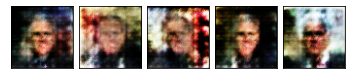

--- EPOCH 68/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.53it/s]
Discriminator loss: 0.45138803124427795
Generator loss:     3.8814277172088625
Saved checkpoint.


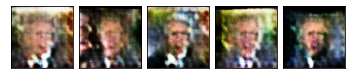

--- EPOCH 69/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.4388358235359192
Generator loss:     4.295009112358093
Saved checkpoint.


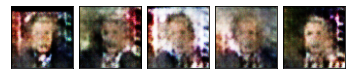

--- EPOCH 70/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.70it/s]
Discriminator loss: 0.5918327167630195
Generator loss:     4.372790050506592
Saved checkpoint.


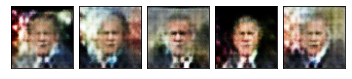

--- EPOCH 71/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.52it/s]
Discriminator loss: 0.8079282522201539
Generator loss:     4.268013727664948
Saved checkpoint.


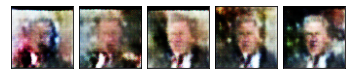

--- EPOCH 72/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.70it/s]
Discriminator loss: 0.6094770461320878
Generator loss:     3.919327986240387
Saved checkpoint.


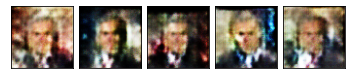

--- EPOCH 73/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.72it/s]
Discriminator loss: 0.5226304024457932
Generator loss:     3.9204873561859133
Saved checkpoint.


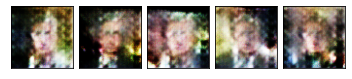

--- EPOCH 74/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.39636645317077634
Generator loss:     3.9129499435424804
Saved checkpoint.


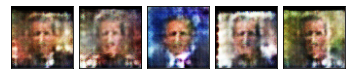

--- EPOCH 75/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
Discriminator loss: 0.44201020151376724
Generator loss:     4.430512189865112
Saved checkpoint.


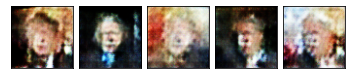

--- EPOCH 76/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.16it/s]
Discriminator loss: 0.7954966098070144
Generator loss:     4.257281732559204
Saved checkpoint.


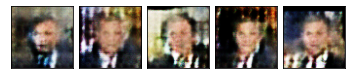

--- EPOCH 77/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.85it/s]
Discriminator loss: 0.46109566986560824
Generator loss:     4.23495192527771
Saved checkpoint.


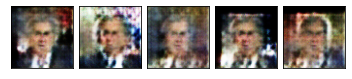

--- EPOCH 78/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
Discriminator loss: 0.5106001228094101
Generator loss:     4.337576508522034
Saved checkpoint.


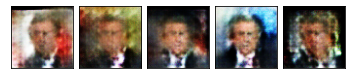

--- EPOCH 79/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.38396887481212616
Generator loss:     3.7705891847610475
Saved checkpoint.


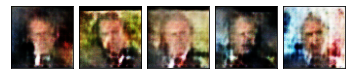

--- EPOCH 80/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.60it/s]
Discriminator loss: 0.8788712620735168
Generator loss:     4.5376697182655334
Saved checkpoint.


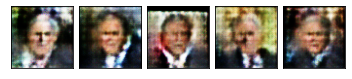

--- EPOCH 81/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.89it/s]
Discriminator loss: 0.7600550830364228
Generator loss:     3.9247063040733337
Saved checkpoint.


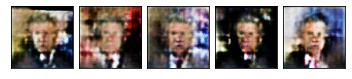

--- EPOCH 82/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.71it/s]
Discriminator loss: 0.4604590892791748
Generator loss:     3.5532166242599486
Saved checkpoint.


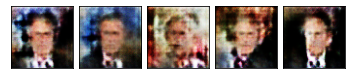

--- EPOCH 83/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.87it/s]
Discriminator loss: 0.456365242600441
Generator loss:     3.8599845290184023
Saved checkpoint.


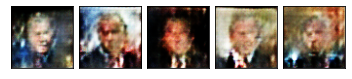

--- EPOCH 84/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.3855010509490967
Generator loss:     3.8361116886138915
Saved checkpoint.


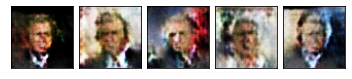

--- EPOCH 85/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.66it/s]
Discriminator loss: 0.3342901438474655
Generator loss:     3.8827863693237306
Saved checkpoint.


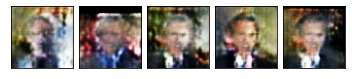

--- EPOCH 86/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.84it/s]
Discriminator loss: 0.42664138674736024
Generator loss:     4.101853656768799
Saved checkpoint.


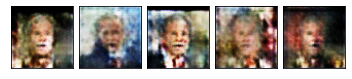

--- EPOCH 87/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.97it/s]
Discriminator loss: 1.0023685723543168
Generator loss:     4.72269161939621
Saved checkpoint.


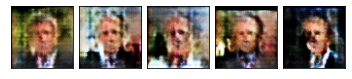

--- EPOCH 88/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.03it/s]
Discriminator loss: 0.5135394871234894
Generator loss:     4.168218445777893
Saved checkpoint.


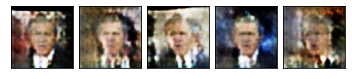

--- EPOCH 89/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.77it/s]
Discriminator loss: 0.4434517383575439
Generator loss:     4.17159116268158
Saved checkpoint.


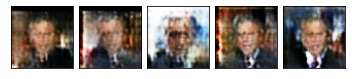

--- EPOCH 90/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.68it/s]
Discriminator loss: 0.44977945685386655
Generator loss:     4.293150758743286
Saved checkpoint.


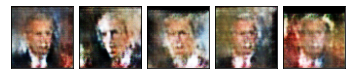

--- EPOCH 91/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.87it/s]
Discriminator loss: 0.4137608379125595
Generator loss:     4.448313021659851
Saved checkpoint.


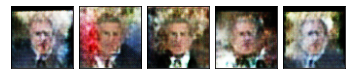

--- EPOCH 92/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
Discriminator loss: 0.45902029126882554
Generator loss:     4.150680136680603
Saved checkpoint.


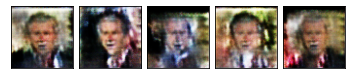

--- EPOCH 93/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.46312746554613116
Generator loss:     4.393922340869904
Saved checkpoint.


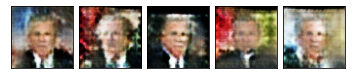

--- EPOCH 94/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.80it/s]
Discriminator loss: 0.6076466649770736
Generator loss:     3.9288782119750976
Saved checkpoint.


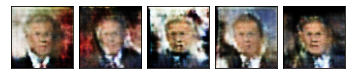

--- EPOCH 95/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.01it/s]
Discriminator loss: 0.40911523401737215
Generator loss:     4.310156011581421
Saved checkpoint.


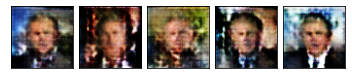

--- EPOCH 96/100 ---
100%|██████████| 10/10 [00:02<00:00,  5.00it/s]
Discriminator loss: 0.43852254152297976
Generator loss:     4.220850253105164
Saved checkpoint.


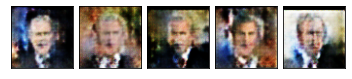

--- EPOCH 97/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.4254766941070557
Generator loss:     3.9055419683456423
Saved checkpoint.


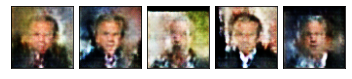

--- EPOCH 98/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.34it/s]
Discriminator loss: 0.35472259521484373
Generator loss:     4.0658056259155275
Saved checkpoint.


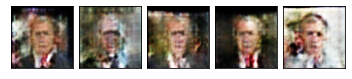

--- EPOCH 99/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.509422904253006
Generator loss:     4.627858221530914
Saved checkpoint.


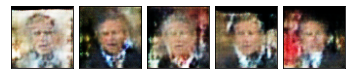

--- EPOCH 100/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.4457730740308762
Generator loss:     4.349199175834656
Saved checkpoint.


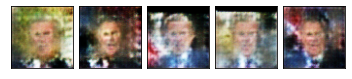

In [125]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


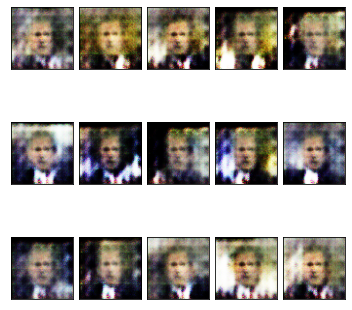

In [122]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [15]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [16]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [17]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [18]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

